# Predicting Grandmasters
## Volume 3 Math 402 Final Project

### Damian and Whitney Anderson,
### Nathan Christiansen, Reagan Howell

#### Date 11/16/2021

# Introduction
Have you ever started playing a game of chess online and wondered if your opponent was one of the top players on lichess.org?

We have ... well, not really, but we were wondering how accurately could you predict your chess opponent based on the moves that they make.
In the past, chess opening moves were studied to find the move order that would give the

So taking the top ~30 players on lichess.org and downloading their classical and rapid format (>25 min and >10 min respectively) games.
With their games in what would it take to help us understand the patterns that these masters are making.

### Importing, Parsing and Cleaning the Data

All games were downloaded from lichess.org open database using links like this

https://lichess.org/api/games/user/Al_shima?rated=true&analysed=true&tags=true&clocks=true&evals=false&opening=false&perfType=rapid

The using regex to remove any of the unimportant information and stripping the .txt files to get the chess game Portable Game Notation (pgn) and the moves that were made.

In [73]:
import os, regex as re, numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV,Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neural_network import MLPClassifier
from statistics import mode
import matplotlib.pyplot as plt

The main function utilizes the create_database() function to access the data files and build our DataFrame. We create a
DataFrame with columns for the players' name, color they were playing as, the variant, and the first 14 moves they make
in their game. We then import that Dataframe into chess_games.csv.


### Creating the X-data and the y-targets

Here we load chess_games.csv and break it into the data and the targets. We hope to predict the name of the Grandmaster
playing the game, so we choose the name column as our targets. We are using the first 14 moves the player makes in order
to predict who is playing, so our data is the 14 columns of moves from each game. We create a train/test split of .75
training and .25 testing.

## Naive Approach
If we just guessed the player with the most games, Rochade_Augsburg, our model would be right 40.73% of the time. So any model that we make should be able to beat this average. 
We started by just taking our train_test_split data and throwing it into all the reasonable machine learning models without any conditions on it. As a baseline measurement we took the mode of the all the players and divided it by the total number of games. 
Running a K-Nearest Neighbors, Multinomial Naive Bayes, a Random Forest, and a MultiLayer Perceptron Classifier, these are their results.

In [7]:
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Color', 'Variant', 'Moves'])
    return data, targets


def sets_():
    data, targets = load_()
    data = pd.get_dummies(data,columns=data.columns)
    xtrain,xtest,ytrain,ytest = train_test_split(data,targets)
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = sets_()

In [37]:
def generate_baseline(ytrain,ytest):
    best_guess = mode(ytrain)
    baseline = sum(ytest == best_guess) / len(ytest)
    return baseline, best_guess
print("Our baseline is {} which we get by guessing {}.".format(*generate_baseline(ytrain,ytest)))

Our baseline is 0.4072910119421747 which we get by guessing Rochade_Augsburg.


Now that we have split the data, we use several classifiers with some adjustments to hyper-parameters to figure out
which combination gives us the most accurate prediction of the Grandmaster playing any given game. In order to make
sure that no classifier got a better split than the others, we (begrudgingly) made the xtrain, xtest, ytrain, and ytest 
variables global and accessible to any function or method.


### KNeighborsClassifier
K Nearest Neighbors

After doing a lot of Grid Searching by "hand", we found this that looking at the 4 nearest neighbors, 
using a distance metric and jst the brute force algorithm resulted in the fastest and highest scoring model type.

%n_neighbors=4,weights='distance',algorithm='brute'

In [8]:
KNeighborsClassifier().fit(xtrain,ytrain).score(xtest,ytest)

0.6272784412319296

### MultinomialNB

In [9]:
MultinomialNB().fit(xtrain,ytrain).score(xtest,ytest)


0.6228786926461345

### Random Forests

In [10]:
RandomForestClassifier().fit(xtrain,ytrain).score(xtest,ytest)


0.6209930861093652

### MLPClassifier

In [13]:
MLPClassifier(hidden_layer_sizes=(50,)).fit(xtrain,ytrain).score(xtest,ytest)



0.6323067253299811

## Looking at Move Order
Our first attempt at refining our classifier was through editing our ‘Moves’ column. Since each game was recorded
as a white move/black move pair and just had another variable that tracked whether or not the player we were anlayzing was playing as white or black, we weren’t actually classifying the players based on their individual moves. Rather, we were classifying them as action-reaction pairs that showed up in their games. To resolve this, we used regular expressions to shift the moves in all games where the player was playing as black. By removing their white opponents’ first move, we were now looking at pairs where it was (player’s move, opponents reaction) in each.

In [9]:
#New data cleaning fucntions
def create_database():
    """
    Calls the files, get_games functions to creates a dataframe
    Returns a dataframe

    """
    file, players = files()
    df = []
    for i in range(len(players)):
        #create a list of all the files and their corresponding players and then input that list into the DataFrame
        df.extend(get_games(path + '/' + file[i], players[i]))
    df = pd.DataFrame(df, columns=['Name', 'Color', 'Variant', 'Moves'])
    df = df[df['Variant'] == 'Standard']
    
    # shift moves
    pattern = re.compile(r"( [0-9]+.)( \S+)")
    for i,m in enumerate(df.Moves):
        if df.iloc[i].Color=='Black':
            new = pattern.sub(r"\2\1",' '+m)
            df.iloc[i].Moves = new[new.find('1'):]
    
    return df
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Color', 'Variant', 'Moves'])
    return data, targets


def sets_():
    data, targets = load_()
    data = pd.get_dummies(data,columns=data.columns)
    xtrain,xtest,ytrain,ytest = train_test_split(data,targets)
    # params = {'n_neighbors': [2,3,4],
    #         'weights' :['uniform','distance'],
    #         'leaf_size' : [30,40,50,60],
    #
    # }
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = sets_()

### KNeighborsClassifier

In [10]:
KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain,ytrain).score(xtest,ytest)

0.6499057196731616

### MultinomialNB

In [11]:
MultinomialNB().fit(xtrain,ytrain).score(xtest,ytest)

0.6197360150848523

### Random Forests

In [13]:
RandomForestClassifier().fit(xtrain,ytrain).score(xtest,ytest)

0.6209930861093652

### MLPClassifier

In [ ]:
MLPClassifier(hidden_layer_sizes=(50,)).fit(xtrain,ytrain).score(xtest,ytest)

### Naive Bayes Classifier

In [16]:
GaussianNB().fit(xtrain,ytrain).score(xtest,ytest)

0.5801382778126964

## Splitting on color
Each of the classifiers gives us about a 60-65% confidence rate in predicting the Grandmaster that we are playing against in any given game. Given that this is from a set of 27 Grandmasters, that means that just a random guess would be correct about 3-4 percent of the time, we feel that this is a pretty good algorithm for prediction.
Next, we will adjust the way that we organize our data. We know that in a game of chess, whether you are playing as white or black vastly changes the sort of strategy that one employs, white being more offensive and black being more defensive. So we will split the data into two databases, separating them based on whether they are playing as black or as white. This may give us a better prediction model as well.
Again, we will try several different classifiers to score our prediction models.

In [24]:
#Getting the White and black data sets
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
    return data, targets


def sets_():
    data, targets = load_()
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    xtrain0,xtest0,ytrain0,ytest0 = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain1,xtest1,ytrain1,ytest1 = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])

    xtrain0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtrain1.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest1.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1

xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1 = sets_()


### KNeighborsClassifier

In [26]:
print('Black Score')
KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.9886363636363636

In [27]:
print('White Score')
KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.9965277777777778

### MultinomialNB

In [28]:
print('Black Score')
MultinomialNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.5409090909090909

In [29]:
print('White Score')
MultinomialNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.3515625

### Random Forests

In [30]:
print('Black Score')
RandomForestClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.7977272727272727

In [31]:
print('White Score')
RandomForestClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.7465277777777778

### MLPClassifier

In [ ]:
print('Black Score')
MLPClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)

In [ ]:
print('White Score')
MLPClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)

### Naive Bayes Classifier

In [32]:
print('Black Score')
GaussianNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.3159090909090909

In [ ]:
print('White Score')
GaussianNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)

###### Why is the K Nearest Neighbors classifier working so well compared to the other classifiers?
K Nearest Neighbors works by looking at the given row of data, and finding the K rows of data that are most similar to the given row. The label that is most common in those K “Nearest Neighbors” is the label that is chosen to classify the given row of data. In our data, this corresponds to looking at the first 15 moves of the given game, and finding games where the first 15 moves were very similar. As with any sort of game involving strategy, people who play the game will find their style of play and regularly fall back on the same moves that are often successful for them. So given a game played by a certain Grandmaster, the games with the most similar moves will be played by themselves, and thus the K Nearest Neighbors classifier was able to recognize the person who played the game.

###### W

In [63]:
def sets_():
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

b_xtrain,b_xtest,b_ytrain,b_ytest = sets_()
#black
black_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(b_xtrain,b_ytrain).predict(b_xtest)
black_score = sum(black_predict == b_ytest) / len(b_ytest)
def sets_():
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

w_xtrain,w_xtest,w_ytrain,w_ytest = sets_()
#white
white_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(w_xtrain,w_ytrain).predict(w_xtest)
white_score = sum(white_predict == w_ytest) / len(w_ytest)

In [64]:
def confusion_matrix(actual, guesses):
    guesses = np.array(guesses)
    outputs = np.unique(np.concatenate((actual, guesses)))
    output_to_index = dict()
    for i in range(len(outputs)):
        output_to_index[outputs[i]] = i
    
    matrix = np.zeros((len(outputs), len(outputs)))
    
    for i in range(len(actual)):
        matrix[output_to_index[actual[i]], output_to_index[guesses[i]]] += 1
    return outputs, matrix

In [65]:
def summarize_confusion(outputs, matrix):
    for i in range(len(outputs)):
        print(str(outputs[i]) + ":")
        print("Correctly identified " + str(int(matrix[i][i])) + " games out of " + str(int(sum(matrix[i]))) + ".")
        for j in range(len(outputs)):
            if i == j:
                continue
            if matrix[i][j] == 1:
                print(str(int(matrix[i][j])) + " game was misclassified as " + str(outputs[j]) + ".")
            if matrix[i][j] > 1:
                print(str(int(matrix[i][j])) + " games were misclassified as " + str(outputs[j]) + ".")
        print()

Black


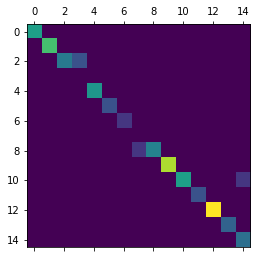

White


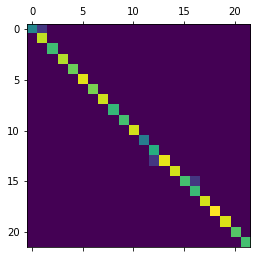

Combined


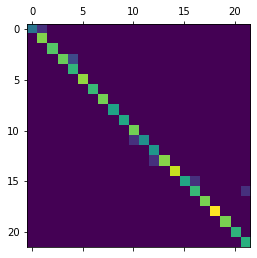

In [74]:
print("Black")
plt.matshow(np.log(black_matrix + 1))
plt.show()
print("White")
plt.matshow(np.log(white_matrix + 1))
plt.show()
print("Combined")
plt.matshow(np.log(matrix + 1))
plt.show()

In [71]:
score = (white_score * len(w_ytest) + black_score * len(b_ytest)) / (len(b_ytest) + len(w_ytest))
print("White classification", white_score)
print("Black classification", black_score)
print("Average score", score)

White classification 0.9959623149394348
Black classification 0.9804878048780488
Average score 0.9926160337552743


## Removing a Player

As data scientists, we have learned to not really trust data. Therefore, we are astounded and amazed at the accuracy of our predicter. We do recognize that over half of our data is games played by one player, Rochade_Augsburg, which could be skewing the accuracy of the predicter by having such a common name to guess. In an attempt to gut check our predicter, we have built a new database with all of Rochade_Augsburg's data removed, so that we can confirm that our predictor is accurate.

In [50]:
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    df,targets = df[df["Name"]!="Rochade_Augsburg"],targets[df["Name"]!="Rochade_Augsburg"]
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
    
    return data, targets


def sets_():
    data, targets = load_()
#     print(data['Unnamed: 0'])
#     print(len(data[data['Unnamed: 0']!="Rochade_Augsburg"]))
#     data,targets = data[data["Name"]!="Rochade_Augsburg"],targets[data["Name"]!="Rochade_Augsburg"]
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    xtrain0,xtest0,ytrain0,ytest0 = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain1,xtest1,ytrain1,ytest1 = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])

    xtrain0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtrain1.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest1.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1

xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1 = sets_()

In [51]:
print("Our new white baseline is {} which we get by guessing {}.".format(*generate_baseline(ytrain1,ytest1)))

Our new white baseline is 0.09825033647375504 which we get by guessing kc6.


In [52]:
print("Our new black baseline is {} which we get by guessing {}.".format(*generate_baseline(ytrain0,ytest0)))

Our new black baseline is 0.36585365853658536 which we get by guessing kc6.


### KNeighborsClassifier

In [53]:
print('Black Score')
KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.975609756097561

In [54]:
print('White Score')
KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.9932705248990579

### MultinomialNB

In [55]:
print('Black Score')
MultinomialNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.22439024390243903

In [56]:
print('White Score')
MultinomialNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.07537012113055182

### Random Forests

In [57]:
print('Black Score')
RandomForestClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.6829268292682927

In [58]:
print('White Score')
RandomForestClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.6958277254374159

### MLPClassifier

In [59]:
print('Black Score')
MLPClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


c:\users\reaga\iclouddrive\college\vol 3\project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7121951219512195

In [60]:
print('White Score')
MLPClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.5935397039030955

### Naive Bayes Classifier

In [61]:
print('Black Score')
GaussianNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)

Black Score


0.11707317073170732

In [62]:
print('White Score')
GaussianNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)

White Score


0.5195154777927322